# Predizione Adozione Animali entro 3 Mesi
## Austin Animal Center - Shelter Intakes and Outcomes

**Obiettivo:** Costruire un modello di Machine Learning che predica se un animale verra adottato entro **90 giorni** dal suo ingresso nel rifugio.

**Perche e utile?** Se il rifugio sa in anticipo quali animali rischiano di restare a lungo, puo:
- Promuoverli di piu sui social / sito web
- Offrire sconti sulle fee di adozione
- Organizzare eventi mirati

**Dataset:** Austin Animal Center (Kaggle) - ~80.000 record con informazioni su ingresso, uscita, razza, eta, colore, condizione, ecc.

---

## 1. Setup - Importazione Librerie/Caricamento Dati
Importiamo tutto quello che ci serve:
- **pandas/numpy**: per manipolare i dati (tabelle, calcoli)
- **matplotlib/seaborn**: per fare grafici
- **sklearn**: la libreria di Machine Learning (modelli, metriche, preprocessing)
- **aac_intakes_outcomes**: carichiamo il file CSV contenente il dataset

In [ ]:
# Data manipulation (pd already loaded in cell 1, re-imported here for self-contained setup)
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: modelling & evaluation
from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    roc_curve, classification_report,
)

# Suppress only convergence / future warnings from sklearn
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Matplotlib style (fallback for older versions)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('seaborn-whitegrid')

plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 11})

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Librerie importate correttamente!')

df = pd.read_csv('aac_intakes_outcomes.csv')

Librerie importate correttamente!


## 2. Caricamento ed Esplorazione dei Dati
Carichiamo il CSV e diamo una prima occhiata: quante righe, quante colonne, che tipo di dati contiene.

In [ ]:
df = pd.read_csv('aac_intakes_outcomes.csv')
print(f'Dataset caricato: {df.shape[0]:,} righe x {df.shape[1]} colonne')
print(f'\nPrime 3 righe:')
df.head(3)

Dataset caricato: 10,772 righe x 41 colonne

Prime 3 righe:


,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650.0,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12.0,2017.0,2017-12,Thursday,14.0,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555.0,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12.0,2014.0,2014-12,Friday,10.0,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190.0,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3.0,2014.0,2014-03,Friday,14.0,3.0,1 days 02:44:00.000000000,1.113889


In [ ]:
print('Colonne e tipi di dato:')
print('=' * 50)
for col in df.columns:
    n_null = df[col].isna().sum()
    null_str = f' ({n_null} mancanti)' if n_null > 0 else ''
    print(f'  {col:<35} {str(df[col].dtype):<10}{null_str}')

Colonne e tipi di dato:
  age_upon_outcome                    object    
  animal_id_outcome                   object    
  date_of_birth                       object     (1 mancanti)
  outcome_subtype                     object     (6694 mancanti)
  outcome_type                        object     (2 mancanti)
  sex_upon_outcome                    object     (2 mancanti)
  age_upon_outcome_(days)             float64    (1 mancanti)
  age_upon_outcome_(years)            float64    (1 mancanti)
  age_upon_outcome_age_group          object     (1 mancanti)
  outcome_datetime                    object     (1 mancanti)
  outcome_month                       float64    (1 mancanti)
  outcome_year                        float64    (1 mancanti)
  outcome_monthyear                   object     (1 mancanti)
  outcome_weekday                     object     (1 mancanti)
  outcome_hour                        float64    (1 mancanti)
  outcome_number                      float64    (1 mancanti)
  dob_y

In [ ]:
df.describe().round(2)

,age_upon_outcome_(days),age_upon_outcome_(years),outcome_month,outcome_year,outcome_hour,outcome_number,dob_year,dob_month,count,age_upon_intake_(days),age_upon_intake_(years),intake_month,intake_year,intake_hour,intake_number,time_in_shelter_days
count,10771.00,10771.00,10771.00,10771.00,10771.00,10771.00,10771.00,10771.00,10771.0,10771.00,10771.00,10771.00,10771.00,10771.00,10771.00,10771.00
mean,1349.90,3.70,6.82,2014.14,14.66,1.19,2010.20,6.82,1.0,1335.91,3.66,7.01,2014.08,13.66,1.19,17.60
std,1306.91,3.58,4.22,1.21,2.95,0.55,3.22,3.80,0.0,1303.80,3.57,4.21,1.21,3.20,0.55,53.66
min,0.00,0.00,1.00,2013.00,0.00,1.00,1994.00,1.00,1.0,0.00,0.00,1.00,2013.00,0.00,1.00,0.00
25%,365.00,1.00,2.00,2013.00,13.00,1.00,2009.00,3.00,1.0,365.00,1.00,2.00,2013.00,11.00,1.00,1.12
50%,730.00,2.00,7.00,2014.00,15.00,1.00,2011.00,7.00,1.0,730.00,2.00,9.00,2014.00,13.00,1.00,4.98
75%,2190.00,6.00,11.00,2015.00,17.00,1.00,2013.00,10.00,1.0,2190.00,6.00,11.00,2015.00,16.00,1.00,12.15
max,7300.00,20.00,12.00,2018.00,23.00,8.00,2016.00,12.00,1.0,7300.00,20.00,12.00,2018.00,23.00,8.00,1606.19


**Cosa notiamo:**
- Il dataset ha 41 colonne - molte sono ridondanti (es. eta in giorni E in anni)
- `time_in_shelter_days` ci dice quanto tempo ogni animale e rimasto nel rifugio - perfetto per il nostro target!
- `outcome_type` ci dice come e finita la storia (Adoption, Transfer, Euthanasia, ecc.)
- Ci sono info su razza, colore, eta, sesso, condizione di ingresso

## 3. Pulizia dei Dati
Prima di analizzare, dobbiamo pulire i dati:
1. **Filtrare solo cani e gatti** - gli altri animali (pipistrelli, procioni, opossum) non sono adottabili per legge
2. **Rimuovere righe con dati mancanti critici**

In [ ]:
print('Tipi di animali nel dataset:')
print(df['animal_type'].value_counts())

# Filtriamo SOLO cani e gatti
df = df[df['animal_type'].isin(['Dog', 'Cat'])].copy()
print(f'Dopo il filtro (solo cani e gatti): {len(df):,} righe')

# ELIMINA RIDONDANTI
colonne_ridondanti = [
    'animal_id_intake', 'animal_id_outcome',
    'age_upon_intake', 'age_upon_outcome',
    'dob_year', 'dob_month', 'dob_monthyear',
    'outcome_monthyear', 'intake_monthyear',
    'outcome_subtype', 'count'
]

colonne_da_rimuovere = [col for col in colonne_ridondanti if col in df.columns]
df = df.drop(columns=colonne_da_rimuovere)
print(f"Eliminate {len(colonne_da_rimuovere)} colonne ridondanti")

Tipi di animali nel dataset:
animal_type
Dog      7863
Cat      2494
Other     404
Bird       10
Name: count, dtype: int64
Dopo il filtro (solo cani e gatti): 10,357 righe
🗑️ Eliminate 11 colonne ridondanti


In [ ]:
# Filtriamo SOLO cani e gatti
df = df[df['animal_type'].isin(['Dog', 'Cat'])].copy()
print(f'Dopo il filtro (solo cani e gatti): {len(df):,} righe')
print(df['animal_type'].value_counts())

Dopo il filtro (solo cani e gatti): 10,357 righe
animal_type
Dog    7863
Cat    2494
Name: count, dtype: int64


In [ ]:
print('Tipi di outcome:')
print(df['outcome_type'].value_counts())

Tipi di outcome:
outcome_type
Adoption           3747
Return to Owner    3432
Transfer           2471
Euthanasia          646
Died                 43
Rto-Adopt            11
Missing               7
Name: count, dtype: int64


In [ ]:
# Rimuoviamo righe con valori mancanti nelle colonne critiche
colonne_critiche = ['sex_upon_intake', 'intake_condition', 'intake_type',
                    'age_upon_intake_(days)', 'outcome_type', 'time_in_shelter_days']
df = df.dropna(subset=colonne_critiche).copy()
print(f'Dopo rimozione mancanti: {len(df):,} righe')

Dopo rimozione mancanti: 10,356 righe


## 4. Definizione del Target
Il nostro **target** (variabile obiettivo) è:
> **adopted_within_90_days** = 1 se l'animale e stato adottato E il tempo in rifugio e <= 90 giorni, 0 altrimenti

Un animale ha label **1** solo se e stato effettivamente adottato entro 3 mesi.
Tutti gli altri (non adottati, adottati dopo 3 mesi, soppressi, trasferiti, ecc.) hanno label **0**.

In [ ]:
df['adopted_within_90_days'] = (
    (df['outcome_type'] == 'Adoption') &
    (df['time_in_shelter_days'] <= 90)
).astype(int)

n_pos = df['adopted_within_90_days'].sum()
n_neg = len(df) - n_pos
pct_pos = n_pos / len(df) * 100

print(f'Distribuzione del target:')
print(f'  NON adottato entro 90gg (0): {n_neg:,} ({100-pct_pos:.1f}%)')
print(f'  Adottato entro 90gg (1): {n_pos:,} ({pct_pos:.1f}%)')

Distribuzione del target:
  NON adottato entro 90gg (0): 6,965 (67.3%)
  Adottato entro 90gg (1): 3,391 (32.7%)


✅ Creati: Cani 7,862 | Gatti 2,494
🔄 Estraendo combinazioni sesso+sterilizzazione...


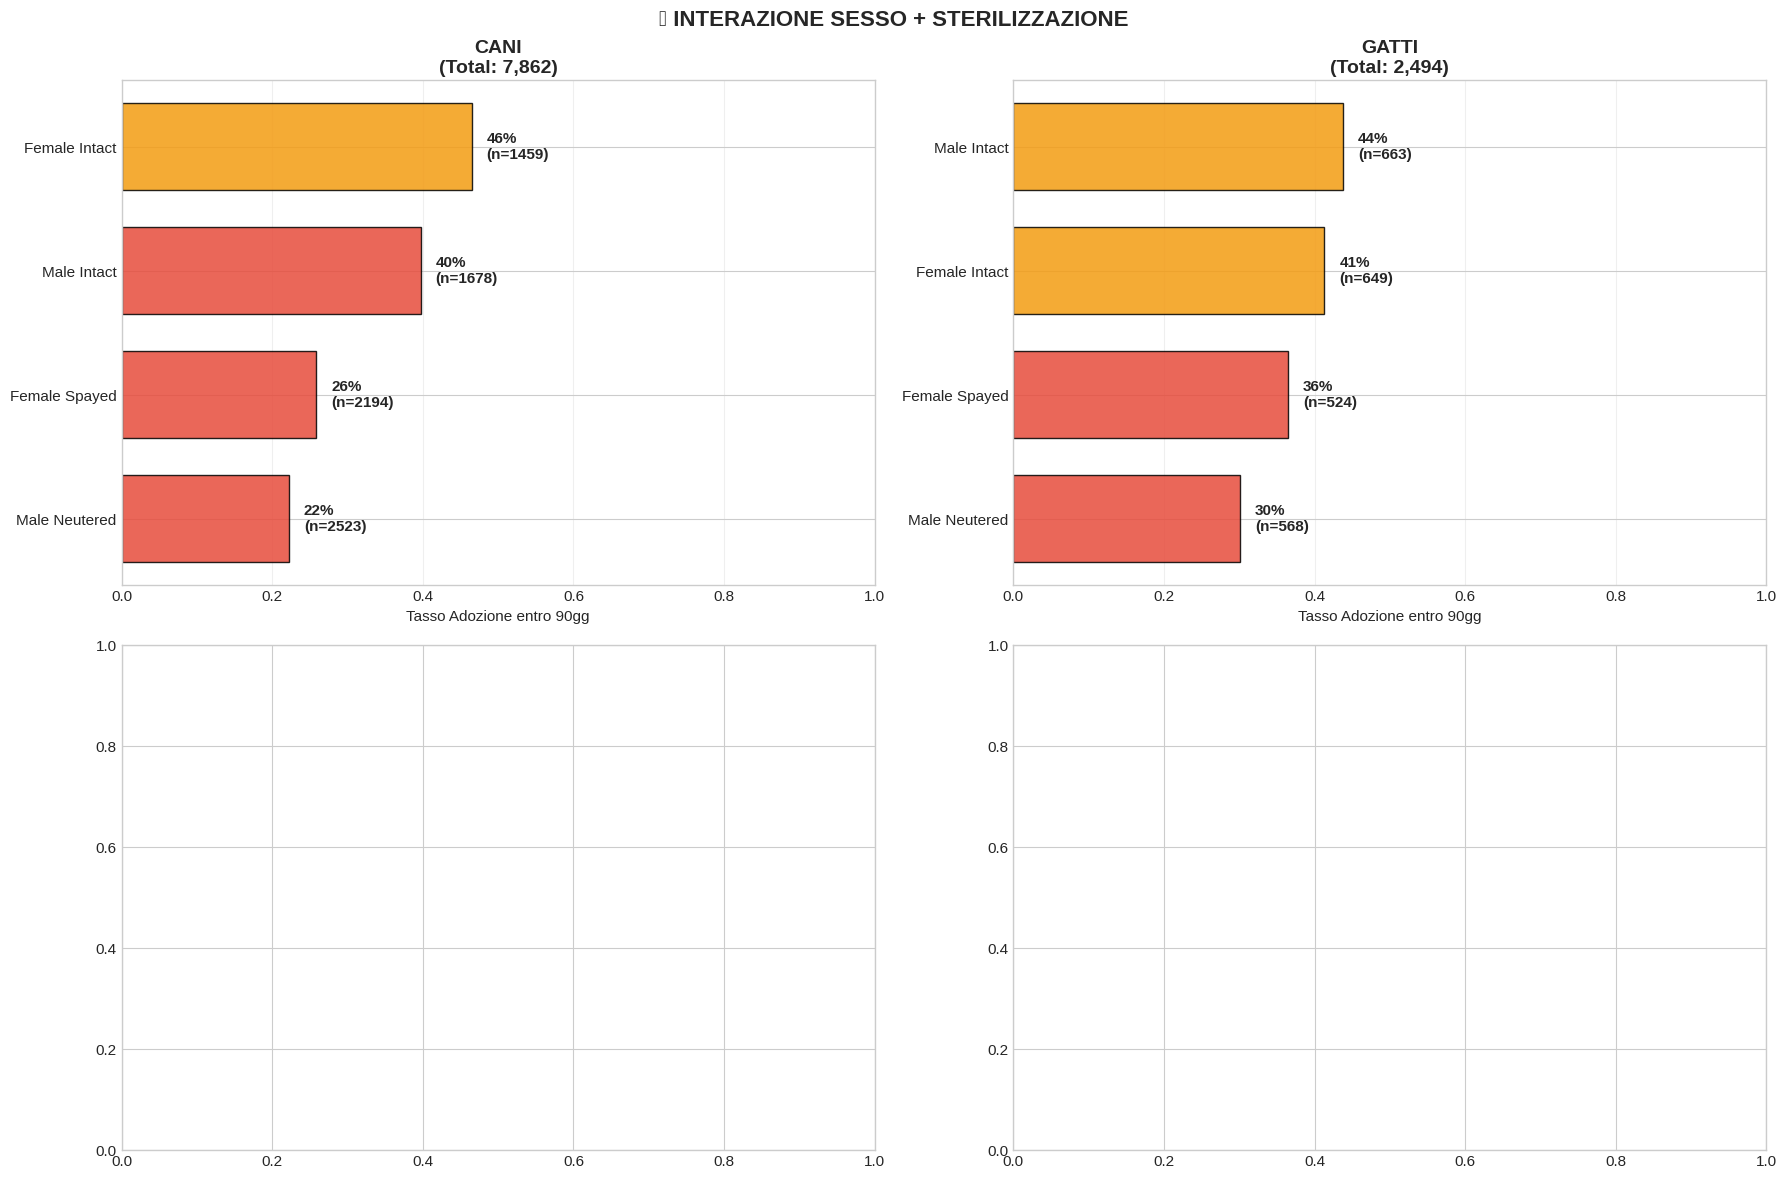


══════════════════════════════════════════════════════════════════════════════════════════
📊 RIEPILOGO TASSI ADOZIONE - MASCHI vs FEMMINE
══════════════════════════════════════════════════════════════════════════════════════════

🐕 CANI:


adopted_within_90_days,total,adoption_rate
sex_neuter,,
Female Intact,1459,0.465
Female Spayed,2194,0.258
Male Intact,1678,0.397
Male Neutered,2523,0.222


   ⚠️  |Male Neutered| - |Female Spayed|: 3.6%

🐱 GATTI:


adopted_within_90_days,total,adoption_rate
sex_neuter,,
Female Intact,649,0.413
Female Spayed,524,0.365
Male Intact,663,0.437
Male Neutered,568,0.301


   ⚠️  |Male Neutered| - |Female Spayed|: 6.3%

══════════════════════════════════════════════════════════════════════════════════════════
✅ SE differenza > 5%, le INTERAZIONI migliorano il modello!


In [ ]:
# MARKDOWN: ## NUOVA SEZIONE: Verifica Interazione Sterilizzazione + Sesso
# Testiamo se maschi/femmine sterilizzati hanno tassi di adozione diversi

# 1. Crea df_dogs e df_cats (SOLO se non esistono)
if 'df_dogs' not in locals():
    df_dogs = df[df['animal_type'] == 'Dog'].copy()
    df_cats = df[df['animal_type'] == 'Cat'].copy()
    print(f"Creati: Cani {len(df_dogs):,} | Gatti {len(df_cats):,}")
else:
    print("df_dogs e df_cats gia' disponibili")

# 2. Funzione ROBUSTA per estrarre sesso + sterilizzazione
def create_sex_neuter_robust(df):
    """Versione robusta che gestisce NaN e formati strani"""
    df = df.copy()

    # Gestione NaN prima
    df['sex_clean'] = df['sex_upon_intake'].fillna('Unknown')

    # Crea colonne separate per sesso e sterilizzazione
    df['gender'] = df['sex_clean'].str.extract(r'(Male|Female)', expand=False).fillna('Unknown')
    df['ster_status'] = df['sex_clean'].str.extract(r'(Neutered|Spayed|Intact)', expand=False).fillna('Unknown')

    # Combina solo se entrambi validi
    mask_valid = (df['gender'] != 'Unknown') & (df['ster_status'] != 'Unknown')
    df['sex_neuter'] = 'Unknown'
    df.loc[mask_valid, 'sex_neuter'] = df.loc[mask_valid, 'gender'] + ' ' + df.loc[mask_valid, 'ster_status']

    return df

# Applica
print("Estraendo combinazioni sesso+sterilizzazione...")
df_dogs = create_sex_neuter_robust(df_dogs)
df_cats = create_sex_neuter_robust(df_cats)

# 3. Visualizza
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for idx, (animal_type, data) in enumerate([('CANI', df_dogs), ('GATTI', df_cats)]):

    # Tassi di adozione per combinazione
    rates = data.groupby(['sex_neuter', 'adopted_within_90_days']).size().unstack(fill_value=0)
    rates['total'] = rates.sum(axis=1)
    rates['adoption_rate'] = rates[1] / rates['total']

    # Filtra categorie significative
    rates_filtered = rates[(rates['total'] >= 100)].copy()

    if len(rates_filtered) < 2:
        axes[idx].text(0.5, 0.5, f'Dati insufficienti\nper {animal_type}',
                           ha='center', va='center', fontsize=14, transform=axes[idx].transAxes)
        continue

    # Grafico
    ax = axes[idx]
    rates_sorted = rates_filtered.sort_values('adoption_rate')
    colors = ['#e74c3c' if r < 0.4 else '#f39c12' if r < 0.6 else '#27ae60'
              for r in rates_sorted['adoption_rate']]

    bars = ax.barh(rates_sorted.index, rates_sorted['adoption_rate'],
                   color=colors, edgecolor='black', alpha=0.85, height=0.7)

    ax.set_xlabel('Tasso Adozione entro 90gg')
    ax.set_title(f'{animal_type}\n(Total: {len(data):,})', fontweight='bold', fontsize=14)
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)

    # Valori sulle barre
    for bar, rate, n in zip(bars, rates_sorted['adoption_rate'], rates_sorted['total']):
        ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
               f'{rate:.0%}\n(n={int(n)})', va='center', fontsize=11, fontweight='bold')

plt.suptitle('INTERAZIONE SESSO + STERILIZZAZIONE', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# 4. Tabella comparativa
print("\n" + "═"*90)
print("RIEPILOGO TASSI ADOZIONE - MASCHI vs FEMMINE")
print("═"*90)

for animal_type, data in [('CANI', df_dogs), ('GATTI', df_cats)]:
    print(f"\n{animal_type}:")
    rates = data.groupby(['sex_neuter', 'adopted_within_90_days']).size().unstack(fill_value=0)
    rates['total'] = rates.sum(axis=1)
    rates['adoption_rate'] = rates[1] / rates['total']
    display(rates[rates['total'] >= 100][['total', 'adoption_rate']].round(3))

    # Differenza maschi/femmine sterilizzati
    male_neut = rates.loc[rates.index.str.contains('Male Neutered'), 'adoption_rate']
    female_spay = rates.loc[rates.index.str.contains('Female Spayed'), 'adoption_rate']

    if len(male_neut) > 0 and len(female_spay) > 0:
        diff = abs(male_neut.iloc[0] - female_spay.iloc[0])
        print(f"   |Male Neutered| - |Female Spayed|: {diff:.1%}")

print("\n" + "═"*90)
print("SE differenza > 5%, le INTERAZIONI migliorano il modello!")


## 6. Feature Engineering
Ora trasformiamo le colonne "testuali" in **numeri** che il modello puo capire.
Creiamo variabili binarie (0/1) per ogni caratteristica importante.

In [ ]:
# Tipo animale
df['is_dog'] = (df['animal_type'] == 'Dog').astype(int)

# Eta
df['age_months'] = df['age_upon_intake_(days)'] / 30.44
df['is_puppy_kitten'] = (df['age_months'] < 6).astype(int)
df['is_young'] = ((df['age_months'] >= 6) & (df['age_months'] < 24)).astype(int)
df['is_senior'] = (df['age_months'] >= 120).astype(int)

# Sesso e sterilizzazione
df['is_neutered'] = df['sex_upon_intake'].str.contains('Neutered|Spayed', case=False, na=False).astype(int)
df['is_intact'] = df['sex_upon_intake'].str.contains('Intact', case=False, na=False).astype(int)
df['is_male'] = df['sex_upon_intake'].str.contains('Male', case=False, na=False).astype(int)

# Condizione e tipo ingresso
df['is_normal'] = (df['intake_condition'] == 'Normal').astype(int)
df['is_sick'] = (df['intake_condition'] == 'Sick').astype(int)
df['is_injured'] = (df['intake_condition'] == 'Injured').astype(int)
df['is_stray'] = (df['intake_type'] == 'Stray').astype(int)
df['is_owner_surrender'] = (df['intake_type'] == 'Owner Surrender').astype(int)
df['is_euthanasia_request'] = (df['intake_type'] == 'Euthanasia Request').astype(int)

# Razza e colore
df['is_mix'] = df['breed'].str.contains('Mix', case=False, na=False).astype(int)
df['is_pitbull'] = df['breed'].str.contains('Pit Bull', case=False, na=False).astype(int)
df['is_black'] = df['color'].str.startswith('Black', na=False).astype(int)
df['has_white'] = df['color'].str.contains('White', case=False, na=False).astype(int)

feature_columns = [
    'age_months', 'is_dog', 'is_puppy_kitten', 'is_young', 'is_senior',
    'is_neutered', 'is_intact', 'is_male', 'is_normal', 'is_sick', 'is_injured',
    'is_stray', 'is_owner_surrender', 'is_euthanasia_request',
    'is_mix', 'is_pitbull', 'is_black', 'has_white'
]

print(f'Feature create: {len(feature_columns)}')

Feature create: 18


In [ ]:
# Lista corretta dei "sopravvissuti" da eliminare
colonne_residue = [
    'intake_datetime', 'outcome_datetime',       # Nomi corretti
    'intake_month', 'intake_year', 'intake_monthyear', 'intake_weekday', 'intake_hour',
    'outcome_month', 'outcome_year', 'outcome_monthyear', 'outcome_weekday', 'outcome_hour',
    'dob_year', 'dob_month', 'dob_monthyear',
    'age_upon_outcome', 'age_upon_outcome_(days)', 'age_upon_outcome_(years)', 'age_upon_outcome_age_group',
    'sex_upon_outcome', 'outcome_number', 'intake_number'
]

# Rimuovi
df.drop(columns=[c for c in colonne_residue if c in df.columns], inplace=True, errors='ignore')

print(f"Pulizia completata! Colonne rimanenti: {df.shape[1]}")
print(df.columns.tolist())

Pulizia completata! Colonne rimanenti: 33
['date_of_birth', 'outcome_type', 'animal_type', 'breed', 'color', 'found_location', 'intake_condition', 'intake_type', 'sex_upon_intake', 'age_upon_intake_(days)', 'age_upon_intake_(years)', 'age_upon_intake_age_group', 'time_in_shelter', 'time_in_shelter_days', 'adopted_within_90_days', 'is_dog', 'age_months', 'is_puppy_kitten', 'is_young', 'is_senior', 'is_neutered', 'is_intact', 'is_male', 'is_normal', 'is_sick', 'is_injured', 'is_stray', 'is_owner_surrender', 'is_euthanasia_request', 'is_mix', 'is_pitbull', 'is_black', 'has_white']


## 7. Preprocessing e Train/Test Split
Ora prepariamo i dati per il modello:
1. **Puliamo i NaN** nelle feature
2. **Dividiamo** in Training (80%) e Test (20%)
3. **Standardizziamo** le feature numeriche

In [ ]:
# Separiamo cani e gatti
df_dogs = df[df['animal_type'] == 'Dog'].copy()
df_cats = df[df['animal_type'] == 'Cat'].copy()

print(f'Cani: {len(df_dogs):,} | Gatti: {len(df_cats):,}')
print(f'Cani adottati entro 90gg: {df_dogs["adopted_within_90_days"].sum():,} ({df_dogs["adopted_within_90_days"].mean()*100:.1f}%)')
print(f'Gatti adottati entro 90gg: {df_cats["adopted_within_90_days"].sum():,} ({df_cats["adopted_within_90_days"].mean()*100:.1f}%)')

# Feature columns SENZA 'is_dog' (non serve più)
feature_columns_split = [f for f in feature_columns if f != 'is_dog']

# Funzione per creare train/test split
def prepare_data(dataframe, features):
    X = dataframe[features].copy().fillna(dataframe[features].median())
    y = dataframe['adopted_within_90_days'].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[['age_months']] = scaler.fit_transform(X_train[['age_months']])
    X_test_scaled[['age_months']] = scaler.transform(X_test[['age_months']])

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Prepariamo i dati per cani e gatti
X_train_dogs, X_test_dogs, y_train_dogs, y_test_dogs, scaler_dogs = prepare_data(df_dogs, feature_columns_split)
X_train_cats, X_test_cats, y_train_cats, y_test_cats, scaler_cats = prepare_data(df_cats, feature_columns_split)

print(f'\nDOGS - Training: {len(X_train_dogs):,} | Test: {len(X_test_dogs):,}')
print(f'CATS - Training: {len(X_train_cats):,} | Test: {len(X_test_cats):,}')


Cani: 7,862 | Gatti: 2,494
Cani adottati entro 90gg: 2,471 (31.4%)
Gatti adottati entro 90gg: 920 (36.9%)

DOGS - Training: 6,289 | Test: 1,573
CATS - Training: 1,995 | Test: 499


## 8. Modellazione
Proviamo 4 modelli diversi e vediamo quale predice meglio:
1. **Baseline (DummyClassifier)** - Il modello "stupido" che dice sempre la classe piu comune
2. **Logistic Regression** - Modello semplice: pesa ogni feature e decide
3. **Random Forest** - 100 "alberi decisionali" che votano insieme
4. **Gradient Boosting** - Alberi che imparano dagli errori dei precedenti

In [ ]:
models = {
    'Baseline (Dummy)': DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)
}

print('Modelli definiti')
for name in models:
    print(f'  - {name}')

Modelli definiti
  - Baseline (Dummy)
  - Logistic Regression
  - Random Forest
  - Gradient Boosting


## 9. Valutazione sul Test Set
Ora alleniamo i modelli sul training completo e li valutiamo sul test set.
Le metriche:
- **Accuracy**: quante predizioni corrette
- **Precision**: tra quelli predetti adottati, quanti lo sono davvero?
- **Recall**: tra quelli davvero adottati, quanti il modello li ha trovati?
- **F1-Score**: media armonica di Precision e Recall
- **AUC-ROC**: quanto bene il modello distingue le due classi

In [ ]:
def evaluate_models(X_train, X_test, y_train, y_test, animal_name):
    """Allena e valuta tutti i modelli per un tipo di animale"""
    print(f'\n{"="*85}')
    print(f'VALUTAZIONE: {animal_name.upper()}')
    print(f'{"="*85}')

    results = {}
    trained_models = {}

    for name, model in models.items():
        model_copy = clone(model) if hasattr(model, 'get_params') else model
        model_copy.fit(X_train, y_train)
        y_pred = model_copy.predict(X_test)
        y_prob = model_copy.predict_proba(X_test)[:, 1] if hasattr(model_copy, 'predict_proba') else None

        results[name] = {
            'y_pred': y_pred,
            'y_prob': y_prob,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else 0
        }
        trained_models[name] = model_copy

    results_df = pd.DataFrame({
        'Modello': list(results.keys()),
        'Accuracy': [r['accuracy'] for r in results.values()],
        'Precision': [r['precision'] for r in results.values()],
        'Recall': [r['recall'] for r in results.values()],
        'F1-Score': [r['f1'] for r in results.values()],
        'AUC-ROC': [r['roc_auc'] for r in results.values()]
    })

    print(results_df.round(4).to_string(index=False))

    best_model = results_df.loc[results_df['F1-Score'].idxmax(), 'Modello']
    best_f1 = results_df['F1-Score'].max()
    print(f'\nMiglior modello {animal_name}: {best_model} (F1 = {best_f1:.4f})')

    return results, results_df, trained_models

# Valuta cani e gatti
results_dogs, df_results_dogs, models_dogs = evaluate_models(
    X_train_dogs, X_test_dogs, y_train_dogs, y_test_dogs, 'Cani'
)

results_cats, df_results_cats, models_cats = evaluate_models(
    X_train_cats, X_test_cats, y_train_cats, y_test_cats, 'Gatti'
)



VALUTAZIONE: CANI
            Modello  Accuracy  Precision  Recall  F1-Score  AUC-ROC
   Baseline (Dummy)    0.6860     0.0000  0.0000    0.0000   0.5000
Logistic Regression    0.6802     0.4939  0.7389    0.5921   0.7483
      Random Forest    0.6891     0.5034  0.7490    0.6021   0.7577
  Gradient Boosting    0.7241     0.5829  0.4271    0.4930   0.7611

Miglior modello Cani: Random Forest (F1 = 0.6021)

VALUTAZIONE: GATTI
            Modello  Accuracy  Precision  Recall  F1-Score  AUC-ROC
   Baseline (Dummy)    0.6313     0.0000  0.0000    0.0000   0.5000
Logistic Regression    0.6593     0.5287  0.7011    0.6028   0.7032
      Random Forest    0.6794     0.5619  0.5924    0.5767   0.7213
  Gradient Boosting    0.6954     0.6159  0.4620    0.5280   0.7342

Miglior modello Gatti: Logistic Regression (F1 = 0.6028)


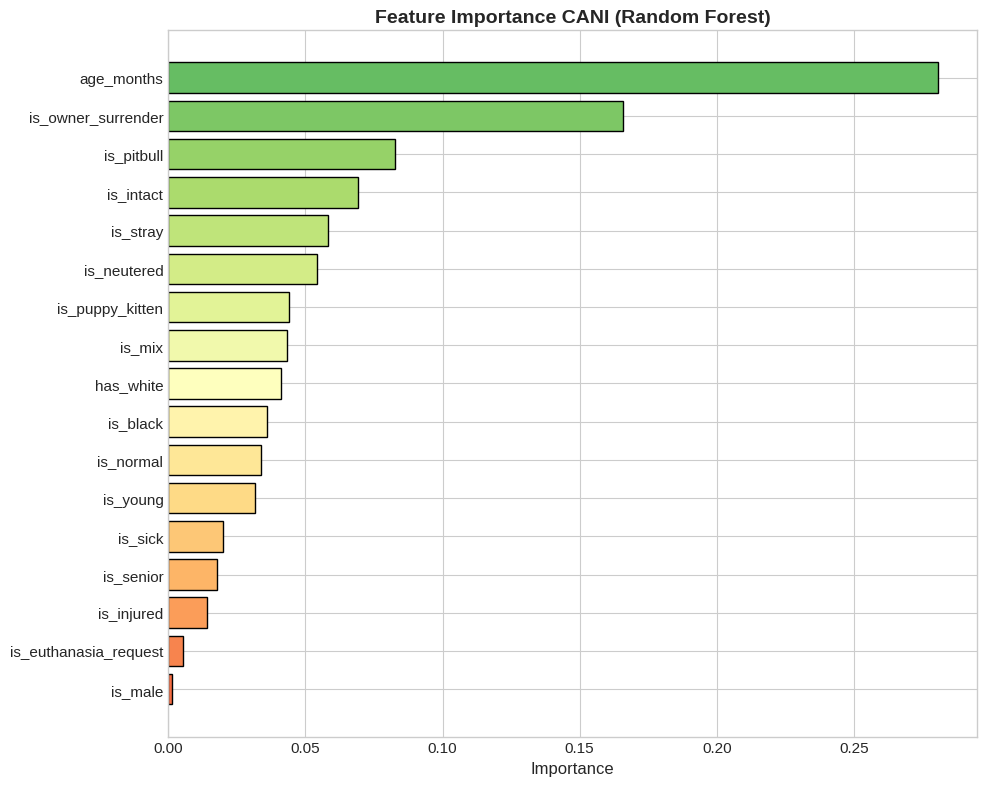


Top 5 feature più importanti per CANI:
  1. age_months: 0.2808
  2. is_owner_surrender: 0.1657
  3. is_pitbull: 0.0828
  4. is_intact: 0.0691
  5. is_stray: 0.0582


In [ ]:
# MARKDOWN: ## 10. Interpretazione del Modello
# Ora cerchiamo di capire **perche** il modello fa certe predizioni per CANI e GATTI separatamente.
# Quali feature contano di piu per ogni specie?

# ### 10.1 Feature Importance (Random Forest) - CANI

# CODE CELLA 1: Feature Importance CANI
rf_dogs = models_dogs['Random Forest']

importance_dogs_df = pd.DataFrame({
    'Feature': feature_columns_split,
    'Importance': rf_dogs.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
colors_imp = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(importance_dogs_df)))
plt.barh(importance_dogs_df['Feature'], importance_dogs_df['Importance'],
         color=colors_imp, edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance CANI (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\nTop 5 feature più importanti per CANI:')
for i, (_, row) in enumerate(importance_dogs_df.tail(5).iloc[::-1].iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Importance']:.4f}")


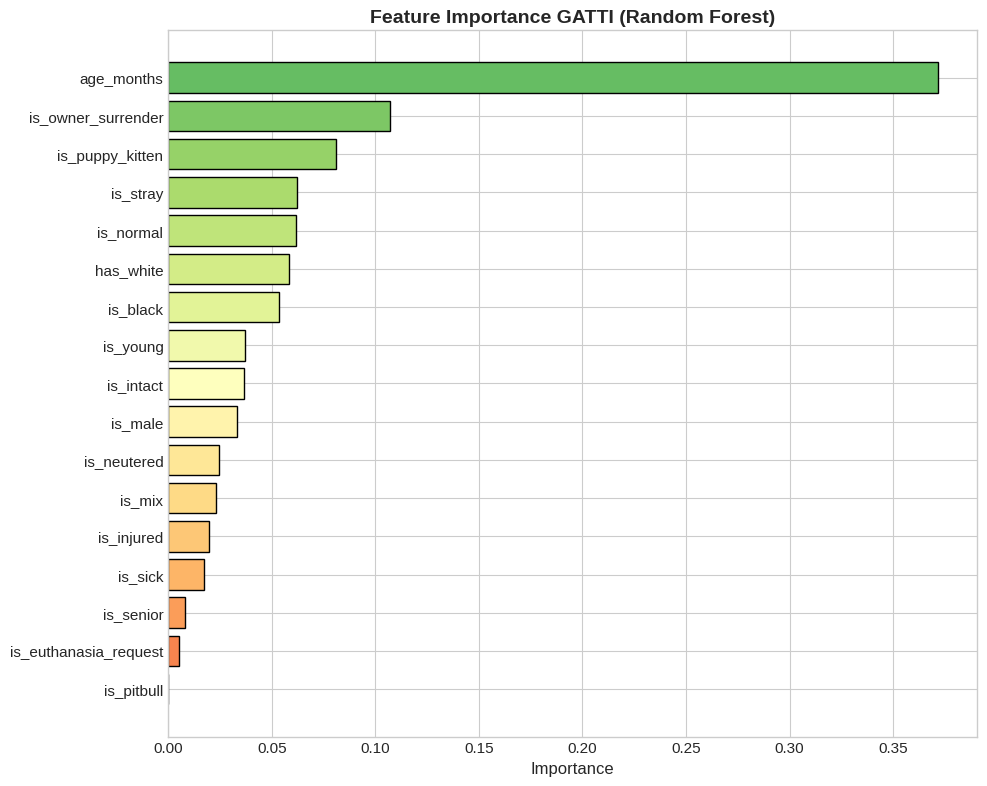


Top 5 feature più importanti per GATTI:
  1. age_months: 0.3719
  2. is_owner_surrender: 0.1072
  3. is_puppy_kitten: 0.0810
  4. is_stray: 0.0621
  5. is_normal: 0.0617


In [ ]:
# ### 10.2 Feature Importance (Random Forest) - GATTI

# CODE CELLA 2: Feature Importance GATTI
rf_cats = models_cats['Random Forest']

importance_cats_df = pd.DataFrame({
    'Feature': feature_columns_split,
    'Importance': rf_cats.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
colors_imp = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(importance_cats_df)))
plt.barh(importance_cats_df['Feature'], importance_cats_df['Importance'],
         color=colors_imp, edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance GATTI (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\nTop 5 feature più importanti per GATTI:')
for i, (_, row) in enumerate(importance_cats_df.tail(5).iloc[::-1].iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Importance']:.4f}")


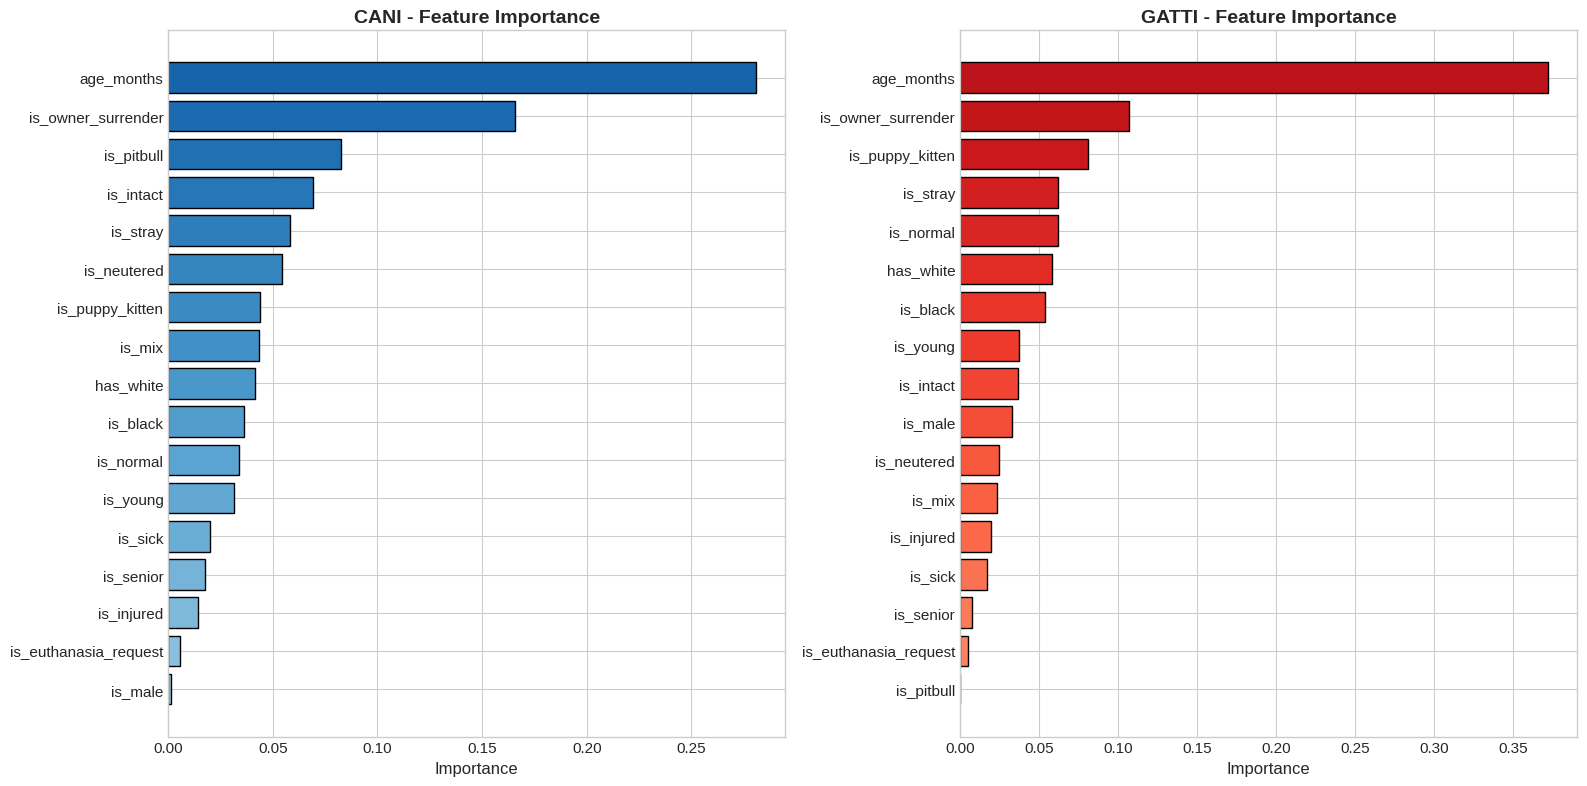

In [ ]:
# ### 10.3 Confronto Feature Importance: CANI vs GATTI

# CODE CELLA 3: Confronto side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# CANI
imp_dogs_sorted = importance_dogs_df.sort_values('Importance', ascending=True)
colors_dogs = plt.cm.Blues(np.linspace(0.4, 0.8, len(imp_dogs_sorted)))
axes[0].barh(imp_dogs_sorted['Feature'], imp_dogs_sorted['Importance'],
             color=colors_dogs, edgecolor='black')
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('CANI - Feature Importance', fontsize=14, fontweight='bold')

# GATTI
imp_cats_sorted = importance_cats_df.sort_values('Importance', ascending=True)
colors_cats = plt.cm.Reds(np.linspace(0.4, 0.8, len(imp_cats_sorted)))
axes[1].barh(imp_cats_sorted['Feature'], imp_cats_sorted['Importance'],
             color=colors_cats, edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('GATTI - Feature Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


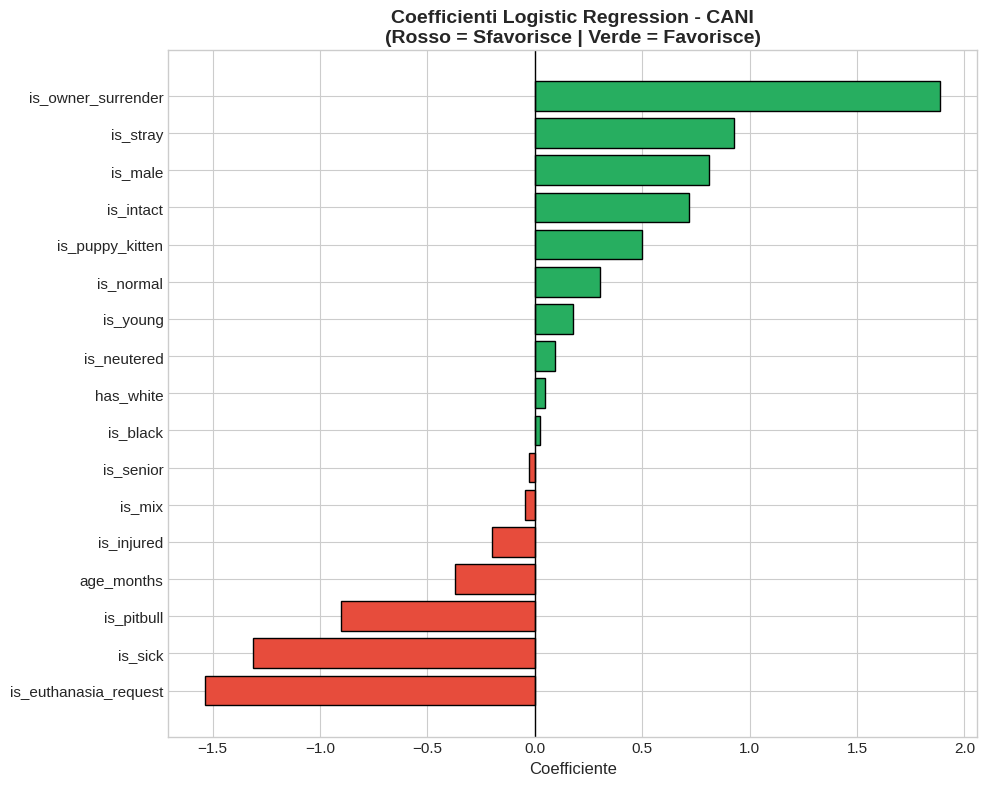

Top 3 coefficienti POSITIVI (favoriscono adozione CANI):
  1. is_owner_surrender: 1.8878
  2. is_stray: 0.9274
  3. is_male: 0.8129

Top 3 coefficienti NEGATIVI (sfavoriscono adozione CANI):
  1. is_euthanasia_request: -1.5361
  2. is_sick: -1.3138
  3. is_pitbull: -0.9047


In [ ]:
# ### 10.4 Coefficienti Logistic Regression - CANI

# CODE CELLA 4: Coefficienti LR CANI
lr_dogs = models_dogs['Logistic Regression']

coef_dogs_df = pd.DataFrame({
    'Feature': feature_columns_split,
    'Coefficiente': lr_dogs.coef_[0]
}).sort_values('Coefficiente')

fig, ax = plt.subplots(figsize=(10, 8))
colors_coef = ['#e74c3c' if c < 0 else '#27ae60' for c in coef_dogs_df['Coefficiente']]
ax.barh(coef_dogs_df['Feature'], coef_dogs_df['Coefficiente'],
        color=colors_coef, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Coefficiente', fontsize=12)
ax.set_title('Coefficienti Logistic Regression - CANI\n(Rosso = Sfavorisce | Verde = Favorisce)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Top 3 coefficienti POSITIVI (favoriscono adozione CANI):')
for i, (_, row) in enumerate(coef_dogs_df.tail(3).iloc[::-1].iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Coefficiente']:.4f}")

print('\nTop 3 coefficienti NEGATIVI (sfavoriscono adozione CANI):')
for i, (_, row) in enumerate(coef_dogs_df.head(3).iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Coefficiente']:.4f}")


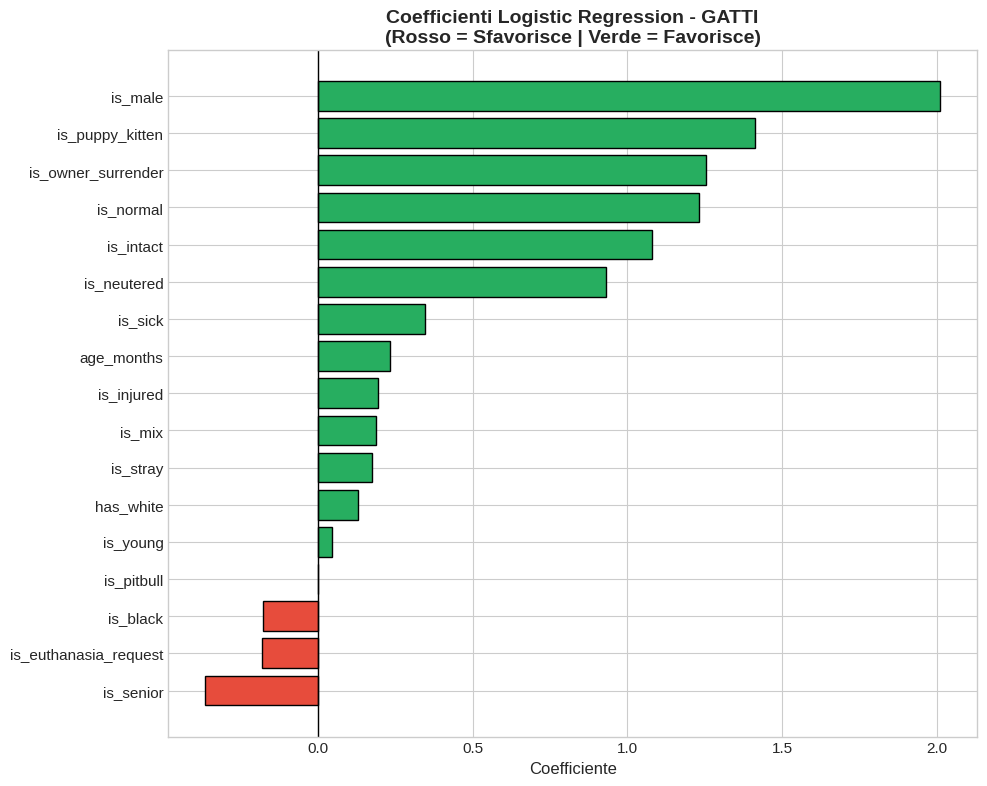

Top 3 coefficienti POSITIVI (favoriscono adozione GATTI):
  1. is_male: 2.0113
  2. is_puppy_kitten: 1.4131
  3. is_owner_surrender: 1.2548

Top 3 coefficienti NEGATIVI (sfavoriscono adozione GATTI):
  1. is_senior: -0.3655
  2. is_euthanasia_request: -0.1812
  3. is_black: -0.1783


In [ ]:
# ### 10.5 Coefficienti Logistic Regression - GATTI

# CODE CELLA 5: Coefficienti LR GATTI
lr_cats = models_cats['Logistic Regression']

coef_cats_df = pd.DataFrame({
    'Feature': feature_columns_split,
    'Coefficiente': lr_cats.coef_[0]
}).sort_values('Coefficiente')

fig, ax = plt.subplots(figsize=(10, 8))
colors_coef = ['#e74c3c' if c < 0 else '#27ae60' for c in coef_cats_df['Coefficiente']]
ax.barh(coef_cats_df['Feature'], coef_cats_df['Coefficiente'],
        color=colors_coef, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Coefficiente', fontsize=12)
ax.set_title('Coefficienti Logistic Regression - GATTI\n(Rosso = Sfavorisce | Verde = Favorisce)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Top 3 coefficienti POSITIVI (favoriscono adozione GATTI):')
for i, (_, row) in enumerate(coef_cats_df.tail(3).iloc[::-1].iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Coefficiente']:.4f}")

print('\nTop 3 coefficienti NEGATIVI (sfavoriscono adozione GATTI):')
for i, (_, row) in enumerate(coef_cats_df.head(3).iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Coefficiente']:.4f}")


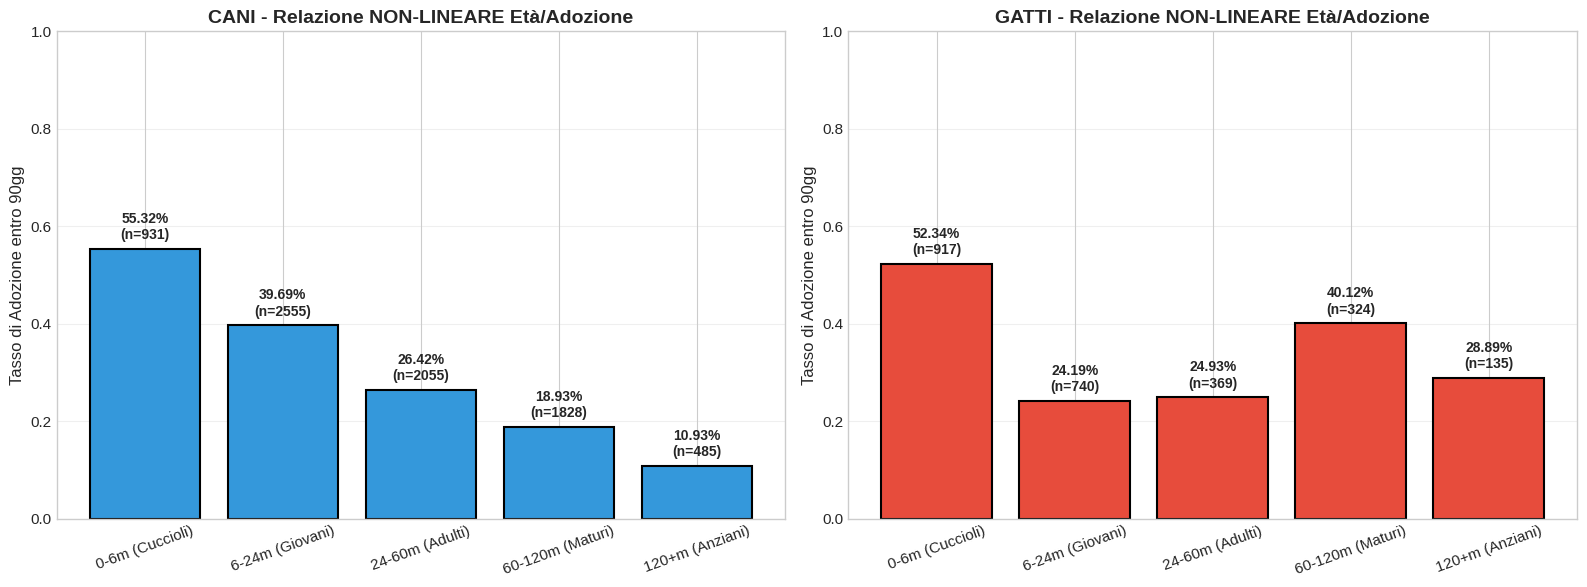

Nota come il tasso di adozione NON scende in modo lineare!
È una CURVA: cuccioli altissimi, poi calo rapido, poi più graduale.
Random Forest cattura questa curva. Logistic Regression cerca una linea retta e fallisce.


In [ ]:
# Analisi della relazione età-adozione (NON LINEARE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (animal_type, data) in enumerate([('CANI', df_dogs), ('GATTI', df_cats)]):
    # Creiamo bin di età
    data['age_bin'] = pd.cut(data['age_months'],
                             bins=[0, 6, 24, 60, 120, 300],
                             labels=['0-6m (Cuccioli)', '6-24m (Giovani)',
                                    '24-60m (Adulti)', '60-120m (Maturi)', '120+m (Anziani)'])

    # Calcoliamo il tasso di adozione per ogni bin
    adoption_rate = data.groupby('age_bin')['adopted_within_90_days'].agg(['mean', 'count'])

    # Grafico
    ax = axes[idx]
    bars = ax.bar(range(len(adoption_rate)), adoption_rate['mean'],
                  color='#3498db' if animal_type == 'CANI' else '#e74c3c',
                  edgecolor='black', linewidth=1.5)

    ax.set_xticks(range(len(adoption_rate)))
    ax.set_xticklabels(adoption_rate.index, rotation=20)
    ax.set_ylabel('Tasso di Adozione entro 90gg', fontsize=12)
    ax.set_title(f'{animal_type} - Relazione NON-LINEARE Età/Adozione',
                fontweight='bold', fontsize=14)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)

    # Aggiungi valori sopra le barre
    for i, (bar, val) in enumerate(zip(bars, adoption_rate['mean'])):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
               f'{val:.2%}\n(n={adoption_rate["count"].iloc[i]})',
               ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print('Nota come il tasso di adozione NON scende in modo lineare!')
print('È una CURVA: cuccioli altissimi, poi calo rapido, poi più graduale.')
print('Random Forest cattura questa curva. Logistic Regression cerca una linea retta e fallisce.')


In [ ]:
# MARKDOWN: ## 6.5 Feature Engineering MIGLIORATO con INTERAZIONI
print("AGGIUNGO INTERAZIONI SESSO+STERILIZZAZIONE")

# FUNZIONE per creare feature interazione (usa df_dogs/df_cats già pronti)
def add_interaction_features(df):
    df = df.copy()

    # Interazioni sesso + sterilizzazione (basate su sex_neuter già estratto)
    df['male_neutered'] = ((df['is_male'] == 1) & (df['is_neutered'] == 1)).astype(int)
    df['female_neutered'] = ((df['is_male'] == 0) & (df['is_neutered'] == 1)).astype(int)
    df['male_intact'] = ((df['is_male'] == 1) & (df['is_intact'] == 1)).astype(int)
    df['female_intact'] = ((df['is_male'] == 0) & (df['is_intact'] == 1)).astype(int)

    return df

# APPLICA
df_dogs = add_interaction_features(df_dogs)
df_cats = add_interaction_features(df_cats)

# NUOVE feature columns (sostituisce le vecchie)
feature_columns_interaction = [f for f in feature_columns_split if f not in ['is_male', 'is_neutered', 'is_intact']]
feature_columns_interaction += ['male_neutered', 'female_neutered', 'male_intact', 'female_intact']

print(f"Nuove feature: {len(feature_columns_interaction)} (aggiunte 4 interazioni)")
print("Nuove:", feature_columns_interaction[-4:])


🎯 AGGIUNGO INTERAZIONI SESSO+STERILIZZAZIONE
✅ Nuove feature: 18 (aggiunte 4 interazioni)
Nuove: ['male_neutered', 'female_neutered', 'male_intact', 'female_intact']
